# Setup

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import umap
import os
os.environ['PYARROW_IGNORE_HOTFIX'] = '1'
from cuml.manifold import UMAP  #GPU-backed
import cupy as cp

/home/jovyan/RW/railverse/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#nomi delle colonne da generare
hmi_status_feats = [
    'Durata','CabEnabled_M1', 'CabEnabled_M8', 'HMI_ACPntSts_T2', 'HMI_ACPntSts_T7', 'HMI_DCPntSts_T2',
    'HMI_DCPntSts_T7', 'HMI_Iline', 'HMI_Irsts_T2', 'HMI_Irsts_T7', 'HMI_VBatt_T2', 'HMI_VBatt_T4', 'HMI_VBatt_T5',
    'HMI_VBatt_T7', 'HMI_Vline', 'HMI_impSIL', 'LineVoltType', 'MDS_LedLimVel', 'MDS_StatoMarcia', '_GPS_LAT',
    '_GPS_LON', 'ldvvelimps', 'ldvveltreno', 'usB1BCilPres_M1', 'usB1BCilPres_M3', 'usB1BCilPres_M6', 'usB1BCilPres_M8',
    'usB1BCilPres_T2', 'usB1BCilPres_T4', 'usB1BCilPres_T5', 'usB1BCilPres_T7', 'usB2BCilPres_M1', 'usB2BCilPres_M3',
    'usB2BCilPres_M6', 'usB2BCilPres_M8', 'usB2BCilPres_T2', 'usB2BCilPres_T4', 'usB2BCilPres_T5', 'usB2BCilPres_T7',
    'usBpPres', 'usMpPres'
]

hmi_status_label = 'ERTMS_PiastraSts'

non_numeric_cols = [
        'Descrizione',
        'Timestamp chiusura',
        'Posizione',
        'Flotta',
        'Veicolo',
        'Codice',
        'Nome',
        'Test',
        'Sistema',
        'Componente',
        'Timestamp segnale']

In [4]:
dataset = pd.read_csv('dataset.csv')
print('intial dataset len', len(dataset), 'column num', len(dataset.columns))
dataset_new = dataset.copy()
dataset_new['Timestamp'] = pd.to_datetime(dataset_new['Timestamp'], errors='coerce')
dataset_new = dataset_new.dropna(subset=['Timestamp'])
print('dropped dataset len', len(dataset_new), 'column num', len(dataset_new.columns))
print("label counts", dataset_new[hmi_status_label].value_counts())
# repeated signals:
dataset_new = dataset_new.drop_duplicates(subset=['Descrizione', 'Timestamp'])
dataset_new.set_index('Timestamp', inplace=True)
dataset_new = dataset_new.dropna(axis=1, how='all')
dataset_new = dataset_new.dropna()
print('after first filtering dataset len', len(dataset_new), 'column num', len(dataset_new.columns))
print("label counts", dataset_new[hmi_status_label].value_counts())



intial dataset len 57652 column num 169
dropped dataset len 57652 column num 169
label counts ERTMS_PiastraSts
1.0    20085
0.0    18703
2.0    17987
Name: count, dtype: int64
after first filtering dataset len 12350 column num 56
label counts ERTMS_PiastraSts
1.0    4575
2.0    4345
0.0    3430
Name: count, dtype: int64


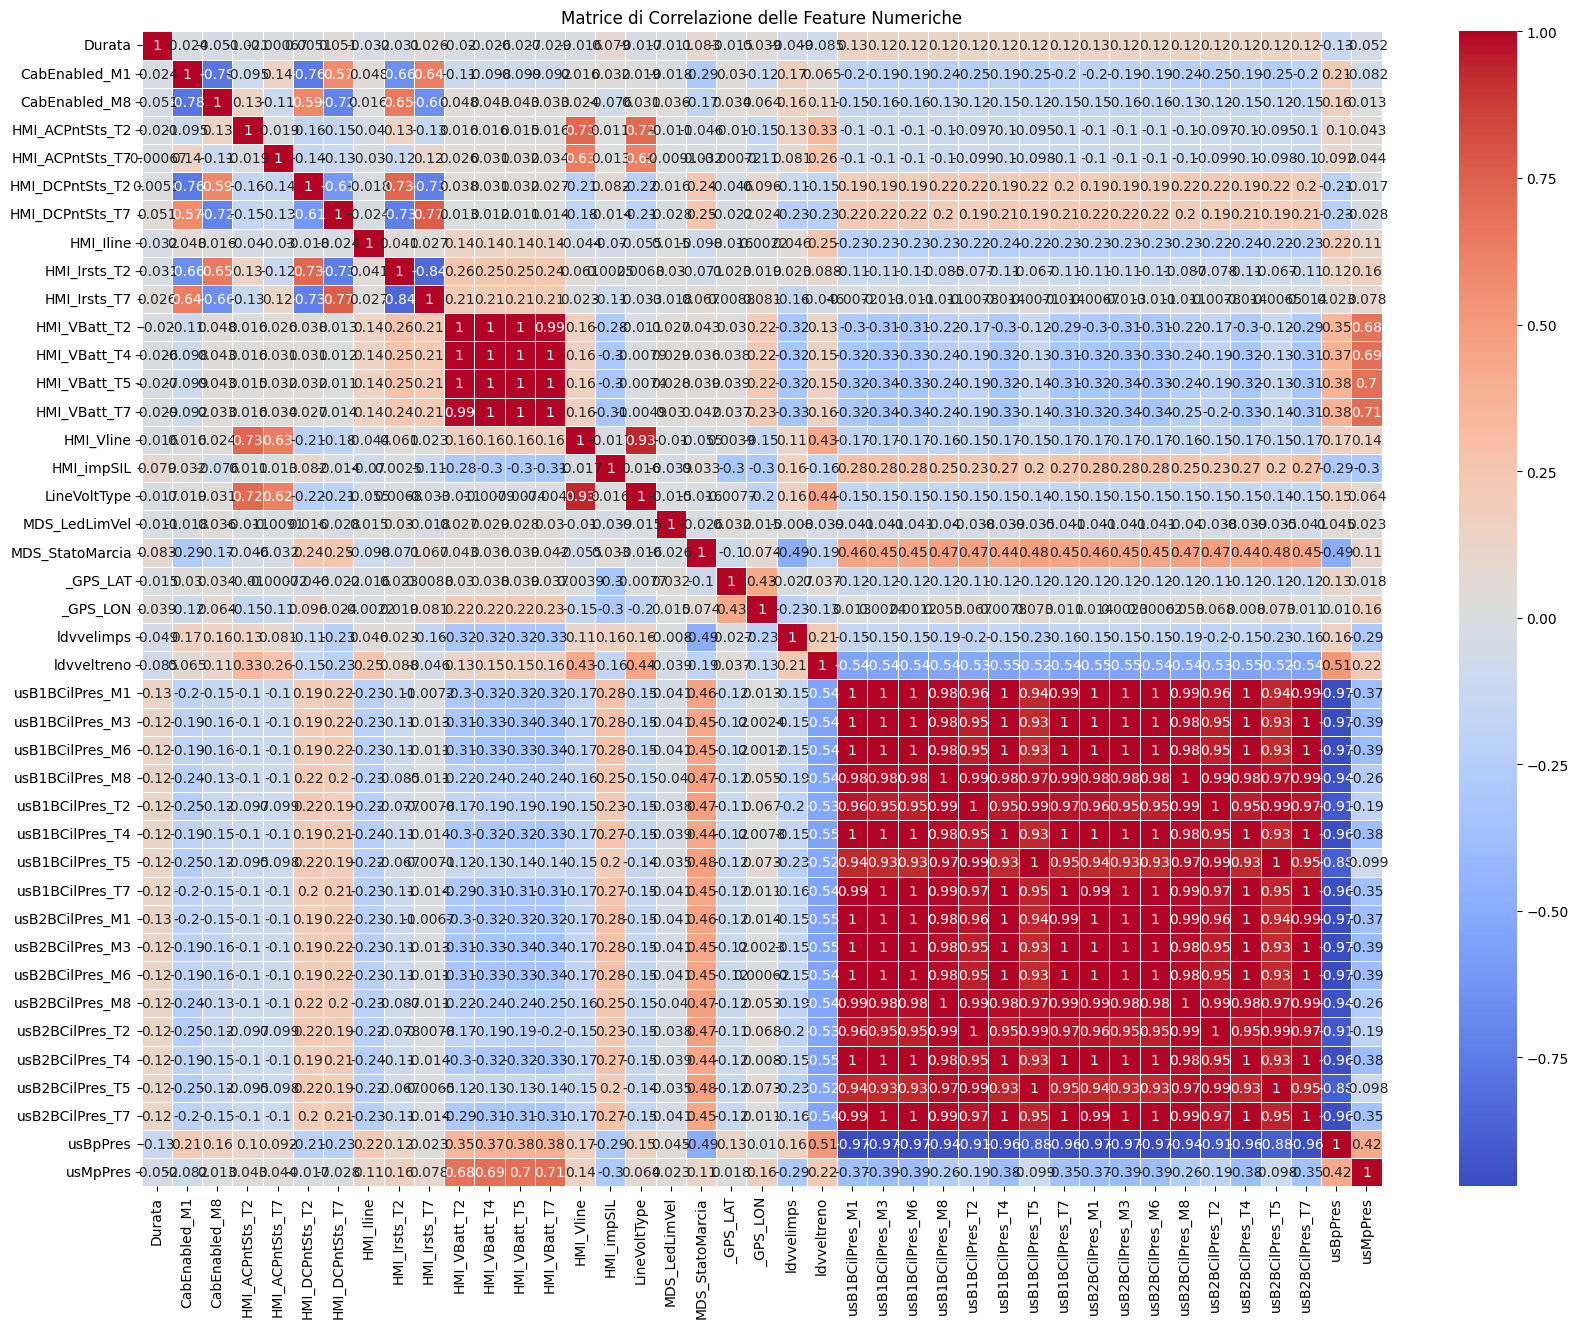

In [5]:
#matrice di correlazione
correlation_matrix = dataset_new[hmi_status_feats].corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matrice di Correlazione delle Feature Numeriche')
plt.show()

In [6]:
no_pressure_feats = [
    'Durata','CabEnabled_M1', 'CabEnabled_M8', 'HMI_ACPntSts_T2', 'HMI_ACPntSts_T7', 'HMI_DCPntSts_T2',
    'HMI_DCPntSts_T7', 'HMI_Iline', 'HMI_Irsts_T2', 'HMI_Irsts_T7', 'HMI_VBatt_T2', 'HMI_VBatt_T4', 'HMI_VBatt_T5',
    'HMI_VBatt_T7', 'HMI_Vline', 'HMI_impSIL', 'LineVoltType', 'MDS_LedLimVel', 'MDS_StatoMarcia', '_GPS_LAT',
    '_GPS_LON', 'ldvvelimps', 'ldvveltreno'
]
no_current_feats = [
    'Durata','CabEnabled_M1', 'CabEnabled_M8', 'LineVoltType', 'MDS_LedLimVel', 'MDS_StatoMarcia', '_GPS_LAT',
    '_GPS_LON', 'ldvvelimps', 'ldvveltreno', 'usB1BCilPres_M1', 'usB1BCilPres_M3', 'usB1BCilPres_M6', 'usB1BCilPres_M8',
    'usB1BCilPres_T2', 'usB1BCilPres_T4', 'usB1BCilPres_T5', 'usB1BCilPres_T7', 'usB2BCilPres_M1', 'usB2BCilPres_M3',
    'usB2BCilPres_M6', 'usB2BCilPres_M8', 'usB2BCilPres_T2', 'usB2BCilPres_T4', 'usB2BCilPres_T5', 'usB2BCilPres_T7',
    'usBpPres', 'usMpPres'
]
no_speed_feats = [
    'Durata','HMI_ACPntSts_T2', 'HMI_ACPntSts_T7', 'HMI_DCPntSts_T2',
    'HMI_DCPntSts_T7', 'HMI_Iline', 'HMI_Irsts_T2', 'HMI_Irsts_T7', 'HMI_VBatt_T2', 'HMI_VBatt_T4', 'HMI_VBatt_T5',
    'HMI_VBatt_T7', 'HMI_Vline', 'HMI_impSIL', 'LineVoltType', 'MDS_LedLimVel', 'MDS_StatoMarcia',
    'usB1BCilPres_M1', 'usB1BCilPres_M3', 'usB1BCilPres_M6', 'usB1BCilPres_M8',
    'usB1BCilPres_T2', 'usB1BCilPres_T4', 'usB1BCilPres_T5', 'usB1BCilPres_T7', 'usB2BCilPres_M1', 'usB2BCilPres_M3',
    'usB2BCilPres_M6', 'usB2BCilPres_M8', 'usB2BCilPres_T2', 'usB2BCilPres_T4', 'usB2BCilPres_T5', 'usB2BCilPres_T7',
    'usBpPres', 'usMpPres'
]

no_cab_enabled_feats = [
    'Durata','HMI_ACPntSts_T2', 'HMI_ACPntSts_T7', 'HMI_DCPntSts_T2',
    'HMI_DCPntSts_T7', 'HMI_Iline', 'HMI_Irsts_T2', 'HMI_Irsts_T7', 'HMI_VBatt_T2', 'HMI_VBatt_T4', 'HMI_VBatt_T5',
    'HMI_VBatt_T7', 'HMI_Vline', 'HMI_impSIL', 'LineVoltType', '_GPS_LAT',
    '_GPS_LON', 'ldvvelimps', 'ldvveltreno', 'usB1BCilPres_M1', 'usB1BCilPres_M3', 'usB1BCilPres_M6', 'usB1BCilPres_M8',
    'usB1BCilPres_T2', 'usB1BCilPres_T4', 'usB1BCilPres_T5', 'usB1BCilPres_T7', 'usB2BCilPres_M1', 'usB2BCilPres_M3',
    'usB2BCilPres_M6', 'usB2BCilPres_M8', 'usB2BCilPres_T2', 'usB2BCilPres_T4', 'usB2BCilPres_T5', 'usB2BCilPres_T7',
    'usBpPres', 'usMpPres'
]

minimal = [
    'Durata', 
    'HMI_DCPntSts_T7', 
    'HMI_VBatt_T7', 'HMI_Vline', 'HMI_impSIL', 'LineVoltType', '_GPS_LAT',
    '_GPS_LON',  
    'usB1BCilPres_T2', 'usB1BCilPres_T4', 'usB1BCilPres_T5', 'usB1BCilPres_T7', 'usB2BCilPres_M1', 'usB2BCilPres_M3',
     'usBpPres',
]



feature_sets = {
    "minimal": minimal,
    "whole": hmi_status_feats, 
    "no_pressure": no_pressure_feats, 
    "no_current": no_current_feats, 
    "no_speed": no_speed_feats,
    "no_cab": no_cab_enabled_feats}

In [7]:
X = dataset_new[hmi_status_feats].values
reducer = umap.UMAP(n_neighbors=25, min_dist=0.1, random_state=42)
# Fit and transform the data
embedding = reducer.fit_transform(X.reshape(X.shape[0], -1))

/home/jovyan/RW/railverse/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/home/jovyan/RW/railverse/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:324: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


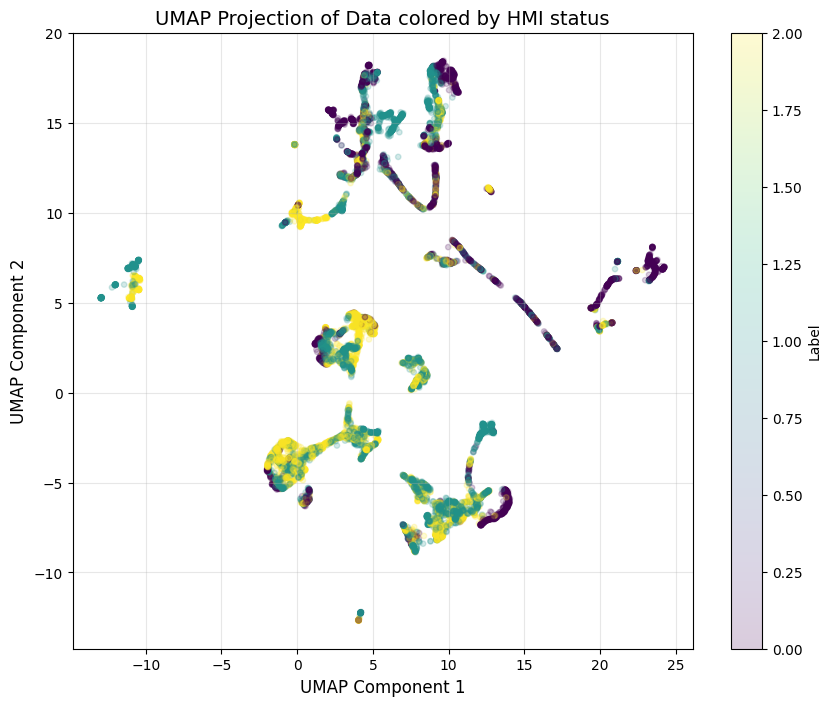

In [23]:
Y_status = dataset_new["ERTMS_PiastraSts"].values
status_ds = dataset_new.drop('ERTMS_PiastraSts', axis=1)

# Visualize the UMAP embedding
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_status, s=15, alpha=0.2)
plt.title('UMAP Projection of Data colored by HMI status', fontsize=14)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
plt.colorbar(label='Label')
plt.grid(True, alpha=0.3)
plt.show()


### GPUS

In [7]:
X = dataset_new[hmi_status_feats].values

# Move to GPU
X_gpu = cp.array(X.reshape(X.shape[0], -1))

reducer = UMAP(n_neighbors=25, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(X_gpu)

# Back to CPU/numpy if needed
embedding = cp.asnumpy(embedding)

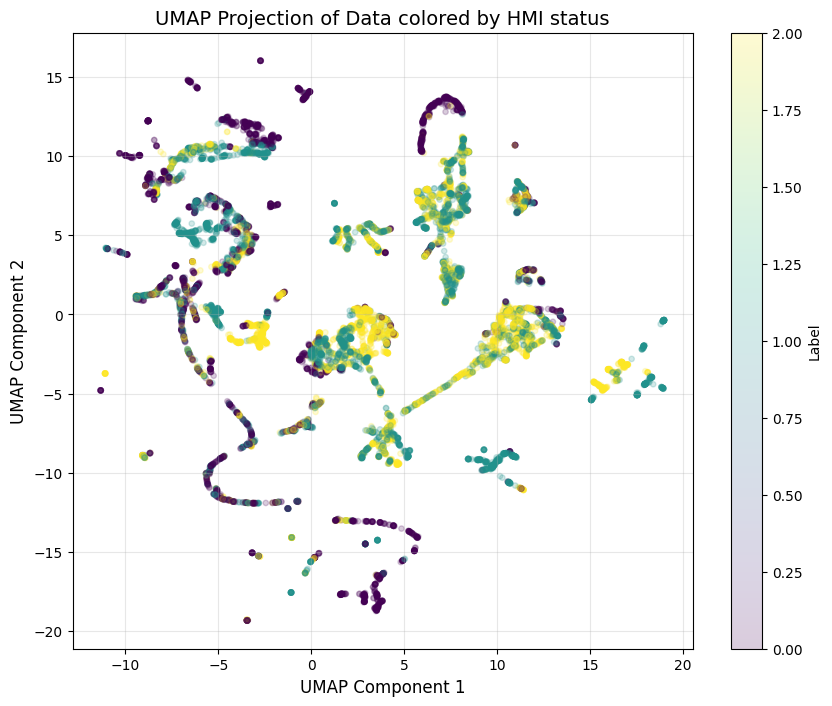

In [8]:
Y_status = dataset_new["ERTMS_PiastraSts"].values
status_ds = dataset_new.drop('ERTMS_PiastraSts', axis=1)

# Visualize the UMAP embedding
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y_status, s=15, alpha=0.2)
plt.title('UMAP Projection of Data colored by HMI status', fontsize=14)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)
plt.colorbar(label='Label')
plt.grid(True, alpha=0.3)
plt.show()


In [9]:
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.optim as optim


class MLP(nn.Module):
    def __init__(self, **kwargs):
        super(MLP, self).__init__()
        input_dim = kwargs.get('input_dim', 40)
        h_dim = kwargs.get('h_dim', 128)
        dropout = kwargs.get('dropout', 0.1)
        num_layers = kwargs.get('num_layers', 3)
        layer_norm = kwargs.get('layer_norm', False)
        output_dim = kwargs.get('output_dim',1)
        self.mode = kwargs.get('mode')
        
        main_stream = []

        if layer_norm:
            main_stream.append(nn.LayerNorm(input_dim))
        
        curr_output_dim = h_dim
        curr_main_input_dim = input_dim

        for _ in range(num_layers):
            main_stream.append(nn.Linear(curr_main_input_dim, curr_output_dim))
            main_stream.append(nn.ReLU())
            main_stream.append(nn.Dropout(dropout))
            curr_main_input_dim = curr_output_dim
            curr_output_dim = curr_output_dim // 2

        # manifold layer:
        curr_output_dim = 2
        self.manifold_layer = nn.Linear(curr_main_input_dim, curr_output_dim)
        curr_main_input_dim = curr_output_dim


        self.output_module = nn.Sequential(
            nn.Linear(curr_main_input_dim, output_dim),
            (nn.Sigmoid() if output_dim == 1 else nn.Softmax(1)))
        
        self.main_stream = nn.Sequential(*main_stream)
        # print("Architecture of the MLP: ")
        # print(self.parameters)
            
    def forward(self, x):
        
        main = self.main_stream(x)
        manifold = self.manifold_layer(main)
        return self.output_module(manifold), manifold.detach()

ModuleNotFoundError: No module named 'torch'

## ablating features:

In [75]:
def plot_results(Y, all_preds, manifold_f, feat_set_name):

    fig, axes = plt.subplots(1, 2, figsize=(20, 4))

    unique_labels = [int(label) for label in np.unique(Y)]
    colors = ['r', 'g', 'b']

    # First subplot
    ax = axes[0]
    for label in unique_labels:
        mask = Y == label
        ax.scatter(manifold_f[mask, 0], manifold_f[mask, 1],
                c=colors[label], s=15, alpha=0.03)
    ax.set_title(f'LABELS {feat_set_name}')
    ax.legend(unique_labels)

    # Second subplot
    ax = axes[1]
    for label in unique_labels:
        mask = all_preds == label
        ax.scatter(manifold_f[mask, 0], manifold_f[mask, 1],
                c=colors[label], s=15, alpha=0.03)
    ax.set_title(f'PREDICTIONS {feat_set_name}')
    ax.legend(unique_labels)

    plt.show()



Accuracy iniziale:  0.37044534412955465


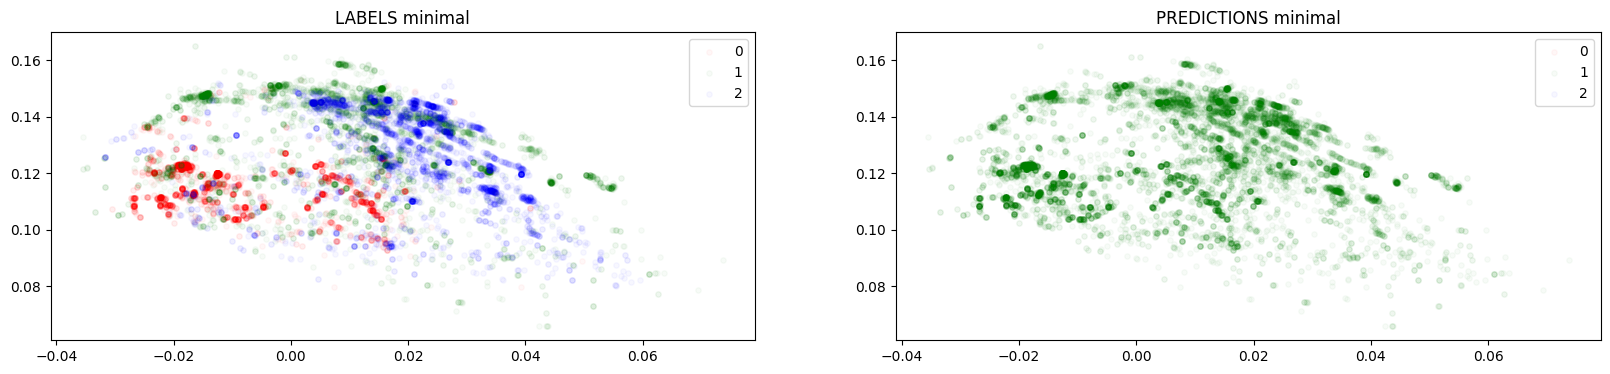

Epoch 1, Test Accuracy: 0.8842
Epoch 11, Test Accuracy: 0.9138
Epoch 21, Test Accuracy: 0.9154
Accuracy finale:  0.9217813765182187


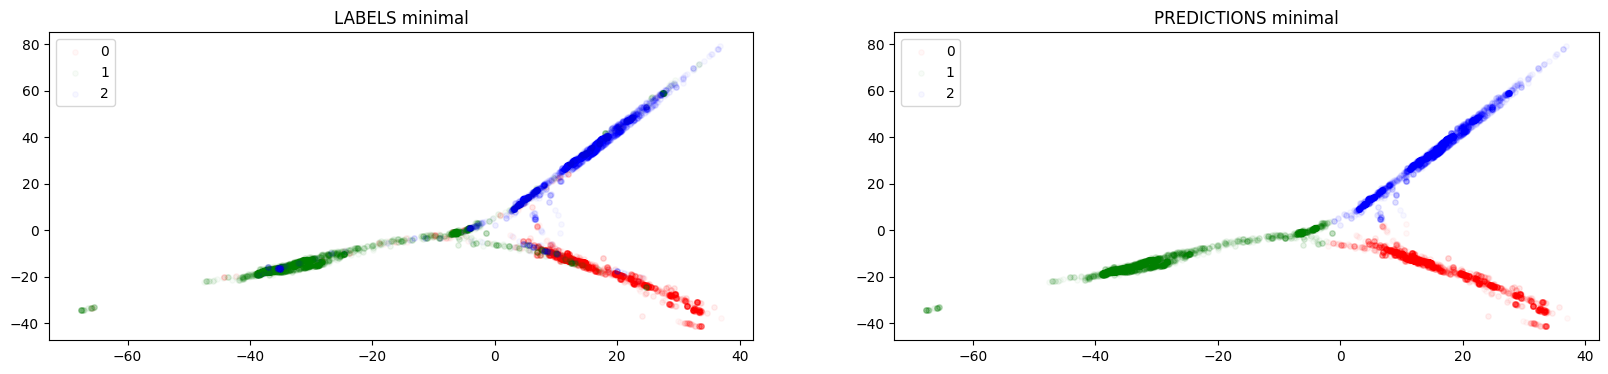

Accuracy iniziale:  0.37044534412955465


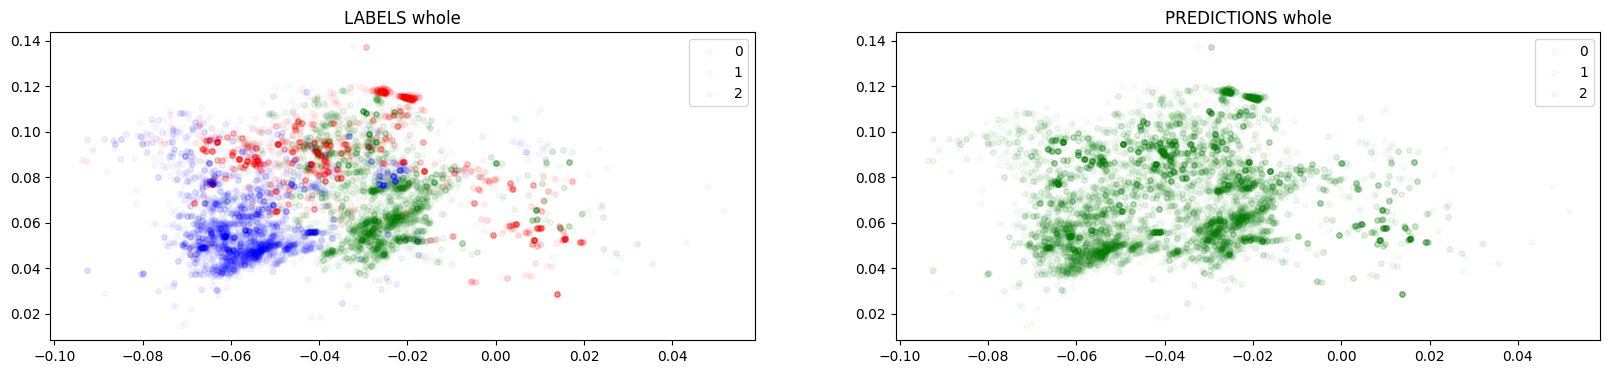

Epoch 1, Test Accuracy: 0.9575
Epoch 11, Test Accuracy: 0.9688
Epoch 21, Test Accuracy: 0.9704
Accuracy finale:  0.9693117408906883


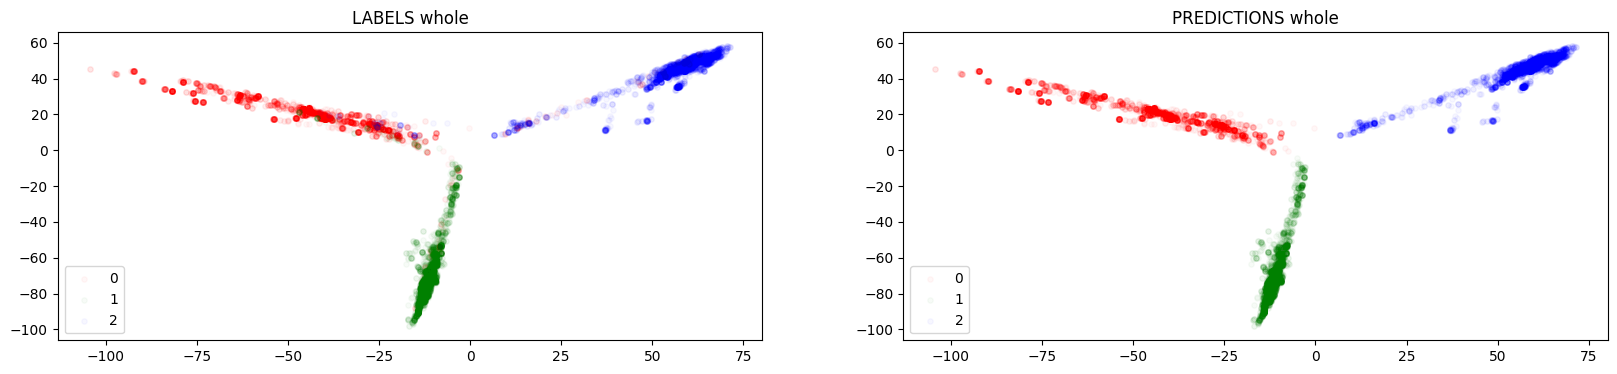

Accuracy iniziale:  0.37044534412955465


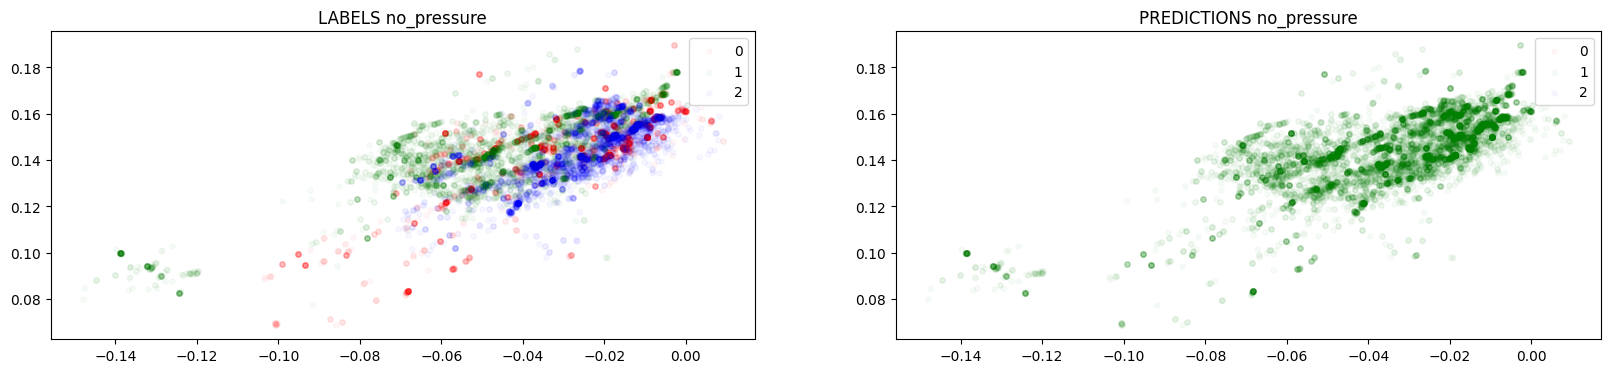

Epoch 1, Test Accuracy: 0.9328
Epoch 11, Test Accuracy: 0.9433
Epoch 21, Test Accuracy: 0.9506
Accuracy finale:  0.9424291497975709


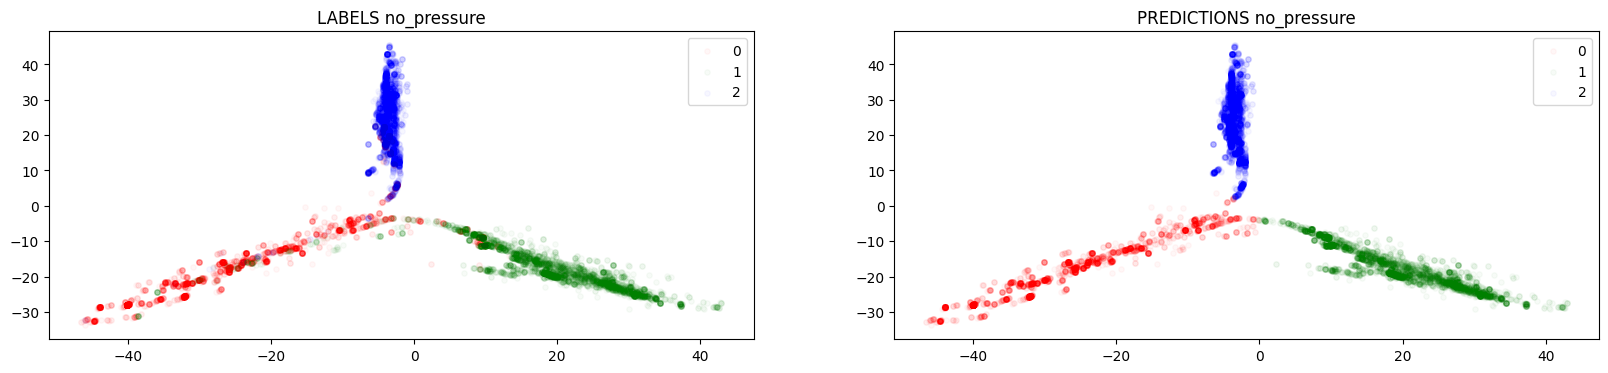

Accuracy iniziale:  0.37044534412955465


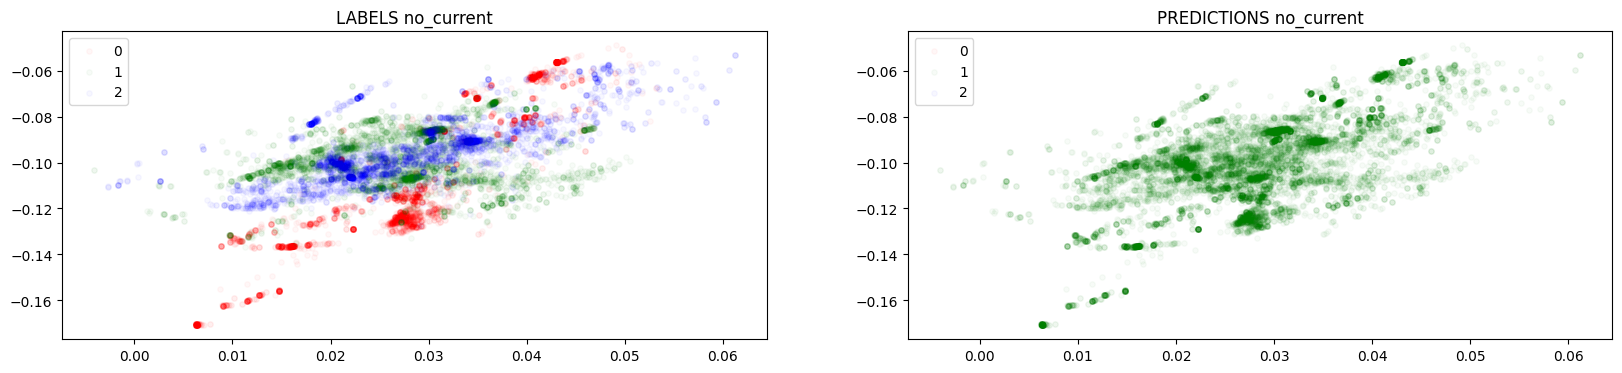

Epoch 1, Test Accuracy: 0.9640
Epoch 11, Test Accuracy: 0.9636
Epoch 21, Test Accuracy: 0.9680
Accuracy finale:  0.9676113360323887


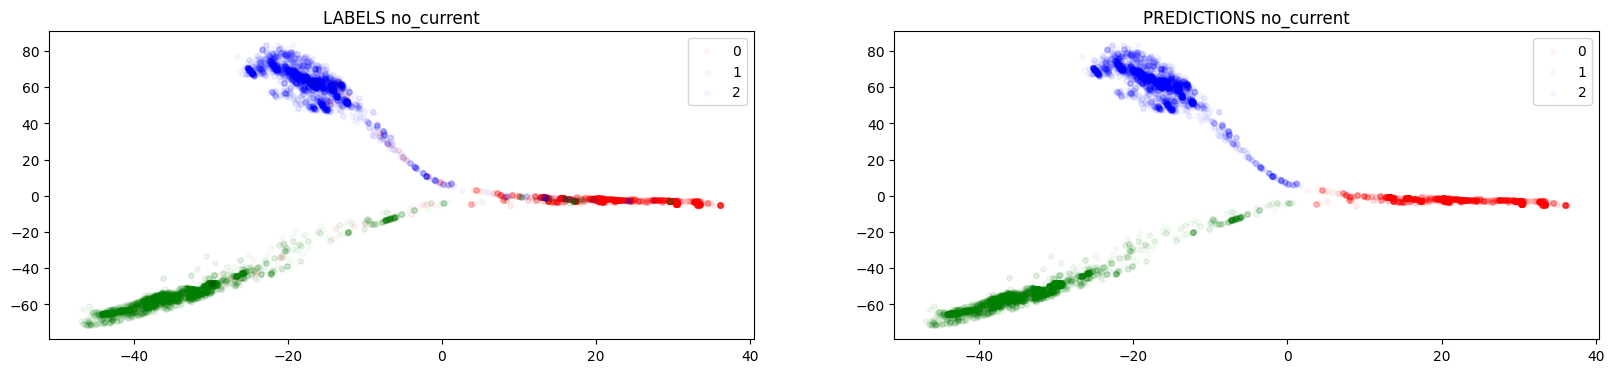

Accuracy iniziale:  0.37044534412955465


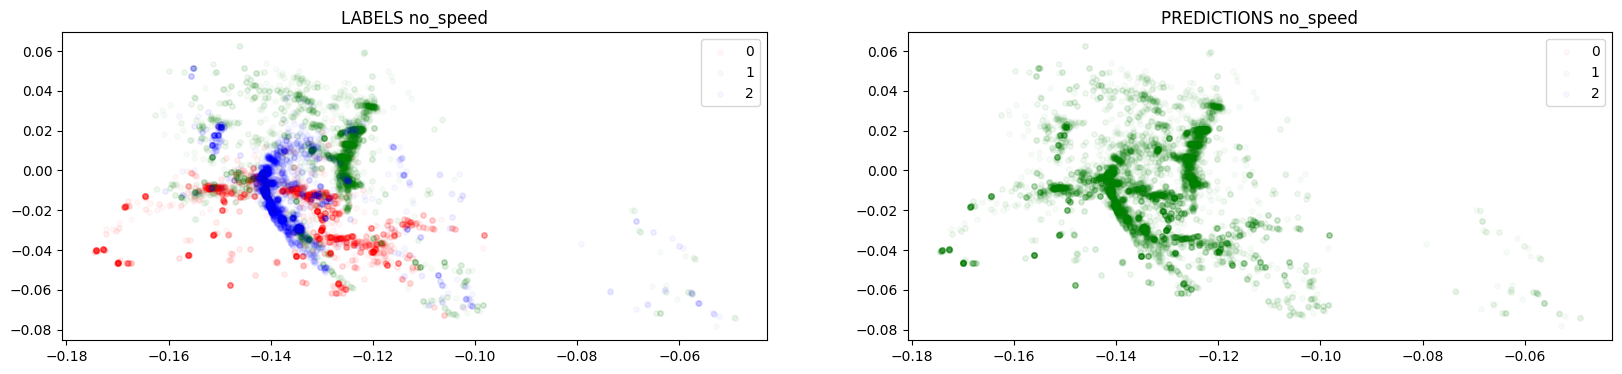

Epoch 1, Test Accuracy: 0.8964
Epoch 11, Test Accuracy: 0.9024
Epoch 21, Test Accuracy: 0.9109
Accuracy finale:  0.9024291497975708


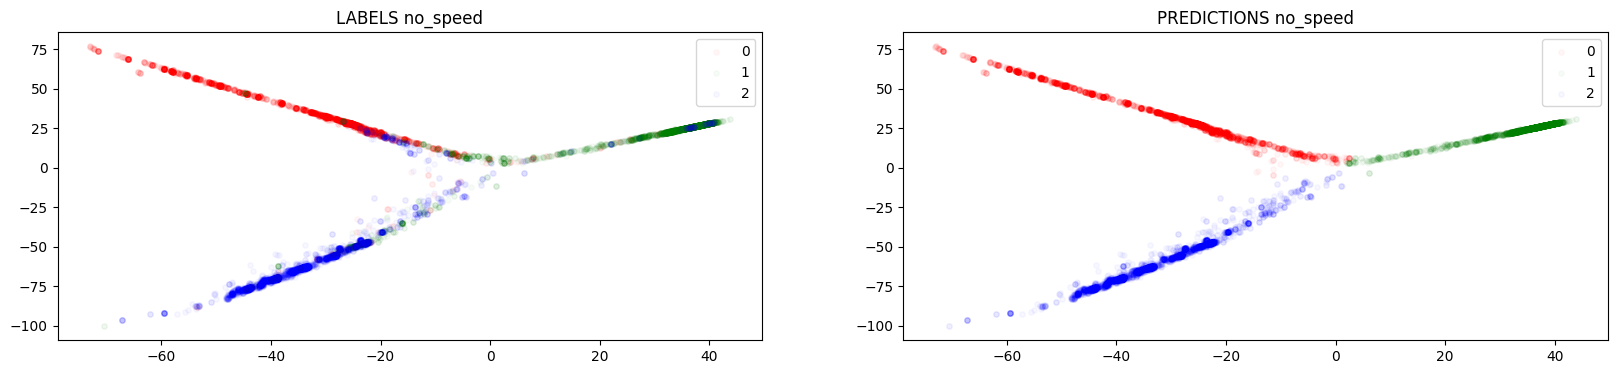

Accuracy iniziale:  0.16161943319838057


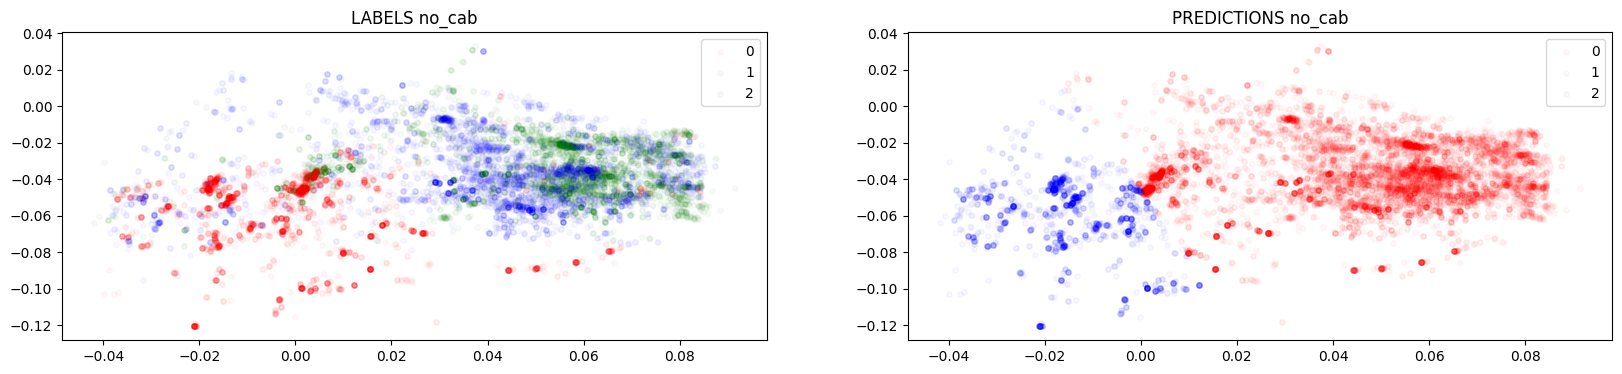

Epoch 1, Test Accuracy: 0.8939
Epoch 11, Test Accuracy: 0.9231
Epoch 21, Test Accuracy: 0.9275
Accuracy finale:  0.9239676113360323


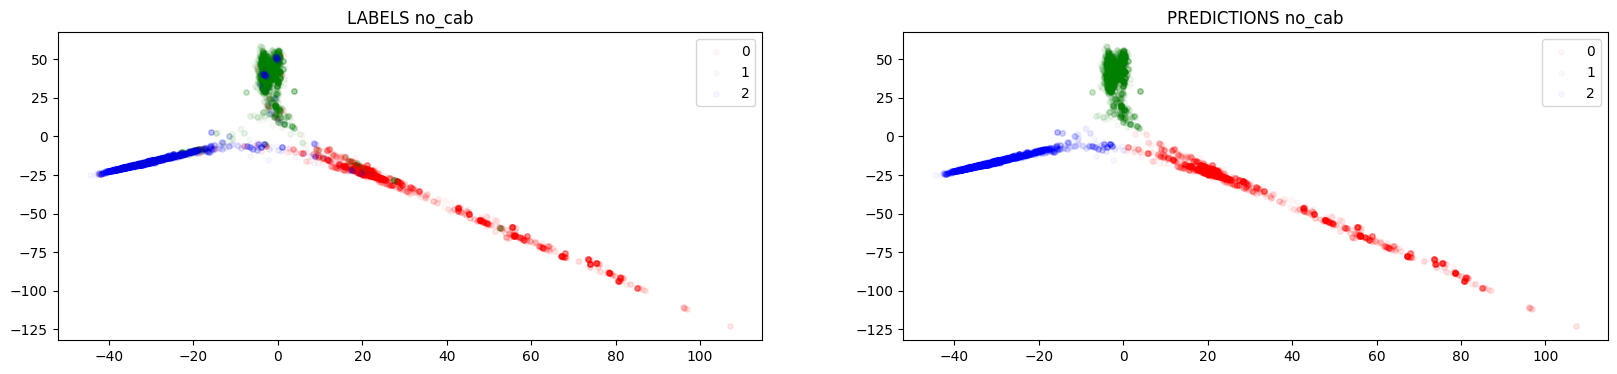

In [78]:
for feat_set_name, feat_set in feature_sets.items():

    X_status = dataset_new[feat_set].values
    anomaly_classifier = MLP(
        **{
            'input_dim': X_status.shape[1],
            'output_dim': 3,
            'layer_norm': True,
            'mode':'OF'})


    Y = Y_status
    X_train, X_test, Y_train, Y_test = train_test_split(X_status, Y, test_size=0.2, random_state=42)

    train_scaler = MinMaxScaler()
    X_train_scaled = train_scaler.fit_transform(X_train)
    X_test_scaled = train_scaler.transform(X_test)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(anomaly_classifier.parameters(), lr=0.001)


    # plotting the manifold before training
    all_X_scaled = train_scaler.transform(X_status)
    all_X_scaled = torch.Tensor(all_X_scaled).float()
    anomaly_classifier.eval()
    all_preds, manifold = anomaly_classifier(all_X_scaled)
    all_preds = torch.argmax(all_preds, dim=1)
    all_correct = (all_preds == Y).sum().item()
    all_accuracy = all_correct / len(Y)
    print("Accuracy iniziale: ", all_accuracy)
    manifold = manifold.numpy()
    
    plot_results(Y,all_preds, manifold, feat_set_name)

    # training

    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(X_train_scaled).float(),
        torch.tensor(Y_train).long())
    test_dataset = torch.utils.data.TensorDataset(
        torch.tensor(X_test_scaled).float(),
        torch.tensor(Y_test).long())

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=32, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=32, shuffle=False)
    
    for epoch in range(30):
        anomaly_classifier.train()
        for x, y in train_dataloader:
            optimizer.zero_grad()
            output, _ = anomaly_classifier(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

        anomaly_classifier.eval()
        total_correct = 0
        with torch.no_grad():
            for x, y in test_dataloader:
                output, _ = anomaly_classifier(x)
                predicted = torch.argmax(output, dim=1)
                total_correct += (predicted == y).sum().item()
        accuracy = total_correct / len(test_dataset)
        if epoch%10==0:
            print(f'Epoch {epoch+1}, Test Accuracy: {accuracy:.4f}')

    # final plot:
    all_X_scaled = train_scaler.transform(X_status)
    all_X_scaled = torch.Tensor(all_X_scaled).float()
    anomaly_classifier.eval()
    all_preds, manifold = anomaly_classifier(all_X_scaled)
    all_preds = torch.argmax(all_preds, dim=1)
    all_correct = (all_preds == Y).sum().item()
    all_accuracy = all_correct / len(Y)
    print("Accuracy finale: ", all_accuracy)
    manifold = manifold.numpy()
    plot_results(Y,all_preds, manifold, feat_set_name)
    

So far, it seems there's no a "silver group" of features... We should ask ourselves if there is a silver bullet...

In [42]:
for silver_bullet_candidate in hmi_status_feats:

    current_feat_set = hmi_status_feats.copy()
    current_feat_set.remove(silver_bullet_candidate)

    X_status = dataset_new[current_feat_set].values
    anomaly_classifier = MLP(
        **{
            'input_dim': X_status.shape[1],
            'output_dim': 3,
            'layer_norm': True,
            'mode':'OF'})


    Y = Y_status
    X_train, X_test, Y_train, Y_test = train_test_split(X_status, Y, test_size=0.2, random_state=42)

    train_scaler = MinMaxScaler()
    X_train_scaled = train_scaler.fit_transform(X_train)
    X_test_scaled = train_scaler.transform(X_test)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(anomaly_classifier.parameters(), lr=0.001)

    # training
    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(X_train_scaled).float(),
        torch.tensor(Y_train).long())
    test_dataset = torch.utils.data.TensorDataset(
        torch.tensor(X_test_scaled).float(),
        torch.tensor(Y_test).long())

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=32, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=32, shuffle=False)
    
    for epoch in range(20):
        anomaly_classifier.train()
        for x, y in train_dataloader:
            optimizer.zero_grad()
            output, _ = anomaly_classifier(x)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

        anomaly_classifier.eval()
        total_correct = 0
        with torch.no_grad():
            for x, y in test_dataloader:
                output, _ = anomaly_classifier(x)
                predicted = torch.argmax(output, dim=1)
                total_correct += (predicted == y).sum().item()
        accuracy = total_correct / len(test_dataset)
        if epoch%10==0:
            # print(f'Epoch {epoch+1}, Test Accuracy: {accuracy:.4f}')
            pass

    # final plot:
    all_X_scaled = train_scaler.transform(X_status)
    all_X_scaled = torch.Tensor(all_X_scaled).float()
    anomaly_classifier.eval()
    all_preds, manifold = anomaly_classifier(all_X_scaled)
    all_preds = torch.argmax(all_preds, dim=1)
    all_correct = (all_preds == Y).sum().item()
    all_accuracy = all_correct / len(Y)
    print(f"Accuracy finale senza {silver_bullet_candidate} : ", all_accuracy) 

Accuracy finale senza Durata :  0.9692307692307692
Accuracy finale senza CabEnabled_M1 :  0.9676113360323887
Accuracy finale senza CabEnabled_M8 :  0.9636437246963563
Accuracy finale senza HMI_ACPntSts_T2 :  0.9678542510121457
Accuracy finale senza HMI_ACPntSts_T7 :  0.9562753036437247
Accuracy finale senza HMI_DCPntSts_T2 :  0.9691497975708502
Accuracy finale senza HMI_DCPntSts_T7 :  0.9661538461538461
Accuracy finale senza HMI_Iline :  0.9710121457489879
Accuracy finale senza HMI_Irsts_T2 :  0.9625910931174089
Accuracy finale senza HMI_Irsts_T7 :  0.9680971659919029
Accuracy finale senza HMI_VBatt_T2 :  0.968744939271255
Accuracy finale senza HMI_VBatt_T4 :  0.9695546558704453
Accuracy finale senza HMI_VBatt_T5 :  0.965506072874494
Accuracy finale senza HMI_VBatt_T7 :  0.9698785425101215
Accuracy finale senza HMI_Vline :  0.9693117408906883
Accuracy finale senza HMI_impSIL :  0.9671255060728745
Accuracy finale senza LineVoltType :  0.9579757085020243
Accuracy finale senza MDS_LedLimV

little difficult to find silver bullets here... let's use math...

# Explaining feat attributions:

In [79]:

X_status = dataset_new[hmi_status_feats].values
anomaly_classifier = MLP(
    **{
        'input_dim': X_status.shape[1],
        'output_dim': 3,
        'layer_norm': True,
        'mode':'OF'})


Y = Y_status
X_train, X_test, Y_train, Y_test = train_test_split(X_status, Y, test_size=0.2, random_state=42)

train_scaler = MinMaxScaler()
X_train_scaled = train_scaler.fit_transform(X_train)
X_test_scaled = train_scaler.transform(X_test)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(anomaly_classifier.parameters(), lr=0.001)

# training

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train_scaled).float(),
    torch.tensor(Y_train).long())
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_test_scaled).float(),
    torch.tensor(Y_test).long())

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False)

for epoch in range(30):
    anomaly_classifier.train()
    for x, y in train_dataloader:
        optimizer.zero_grad()
        output, _ = anomaly_classifier(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

    anomaly_classifier.eval()
    total_correct = 0
    with torch.no_grad():
        for x, y in test_dataloader:
            output, _ = anomaly_classifier(x)
            predicted = torch.argmax(output, dim=1)
            total_correct += (predicted == y).sum().item()
    accuracy = total_correct / len(test_dataset)
    if epoch%10==0:
        print(f'Epoch {epoch+1}, Test Accuracy: {accuracy:.4f}')

# final plot:
all_X_scaled = train_scaler.transform(X_status)
all_X_scaled = torch.Tensor(all_X_scaled).float()
anomaly_classifier.eval()
all_preds, manifold = anomaly_classifier(all_X_scaled)
all_preds = torch.argmax(all_preds, dim=1)
all_correct = (all_preds == Y).sum().item()
all_accuracy = all_correct / len(Y)
print("Accuracy finale: ", all_accuracy)


Epoch 1, Test Accuracy: 0.9628
Epoch 11, Test Accuracy: 0.9696
Epoch 21, Test Accuracy: 0.9603
Accuracy finale:  0.9654251012145749


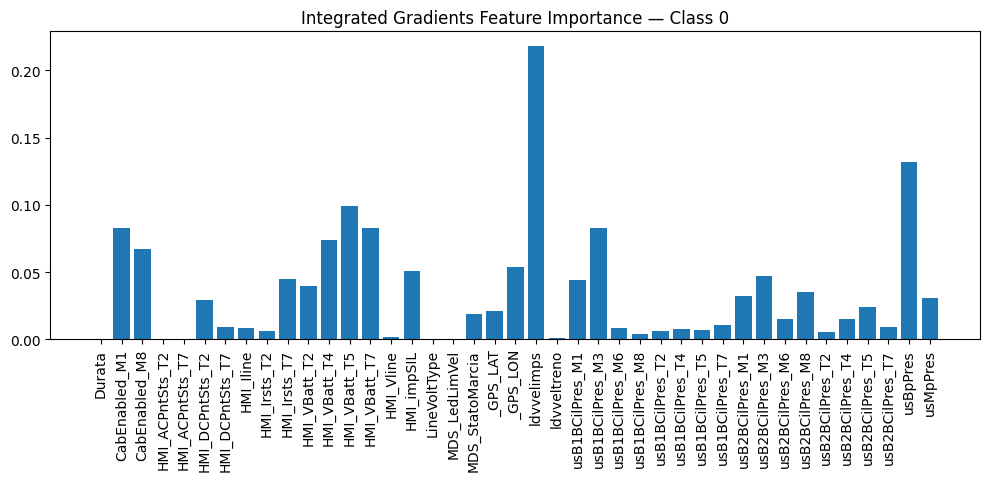

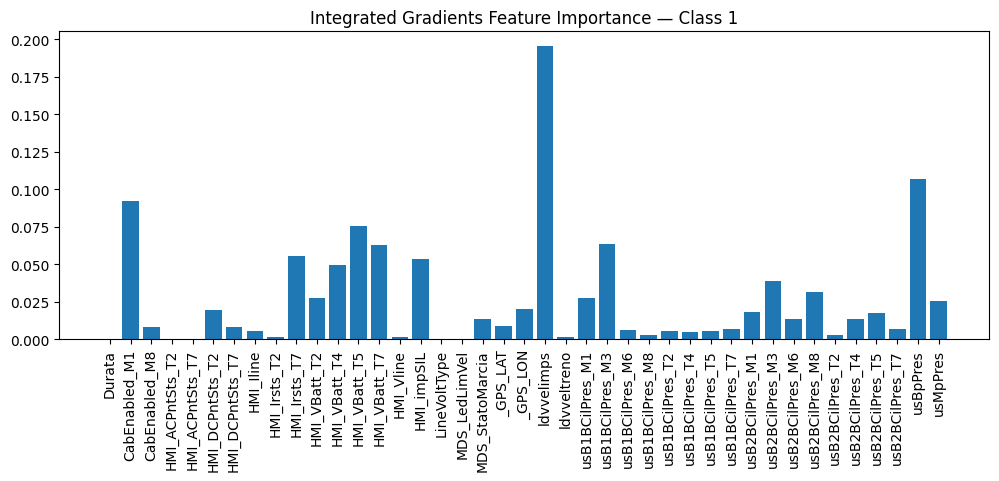

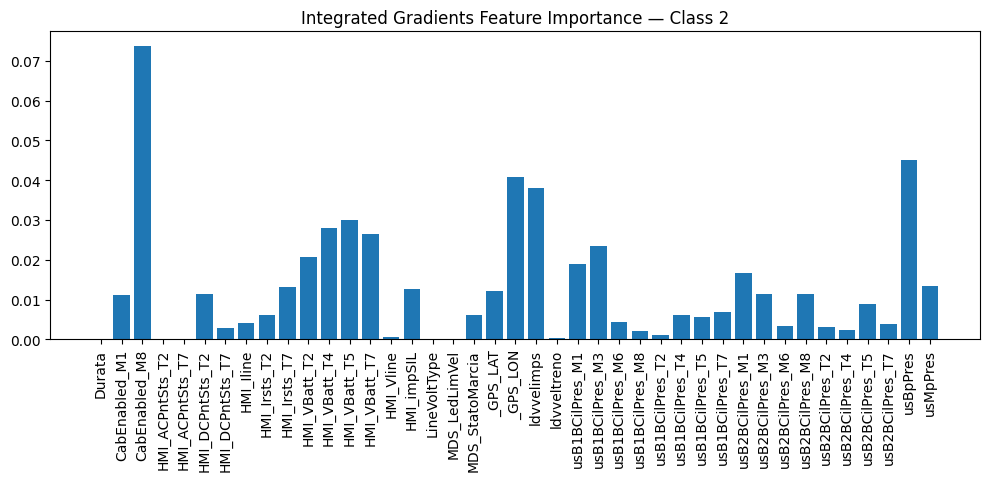

In [80]:
from captum.attr import IntegratedGradients

class MLPLogits(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model

    def forward(self, x):
        logits, _ = self.base(x)
        return logits

logit_model = MLPLogits(anomaly_classifier).eval()

for target_class in [0,1,2]:
        
    ig = IntegratedGradients(logit_model)

    x = torch.tensor(X_test_scaled).float()

    attributions, _ = ig.attribute(
        x,
        target=target_class,
        return_convergence_delta=True,
        n_steps=100
    )

    attr = attributions.detach().numpy()  # shape (N, features)

    mean_attr = np.mean(np.abs(attr), axis=0)

    plt.figure(figsize=(12, 4))
    plt.bar(hmi_status_feats, mean_attr)
    plt.xticks(rotation=90)
    plt.title(f"Integrated Gradients Feature Importance — Class {target_class}")
    plt.show()


There you go, your silver bullets seem to be:

In [81]:
silver_bullets = set(['CabEnabled_M1','CabEnabled_M8', 'usBpPres', 'ldvvelimps', 'HMI_impSIL'])
no_silver_bullet_feat_set = list(set(hmi_status_feats) - set(silver_bullets))

Accuracy iniziale:  0.37044534412955465


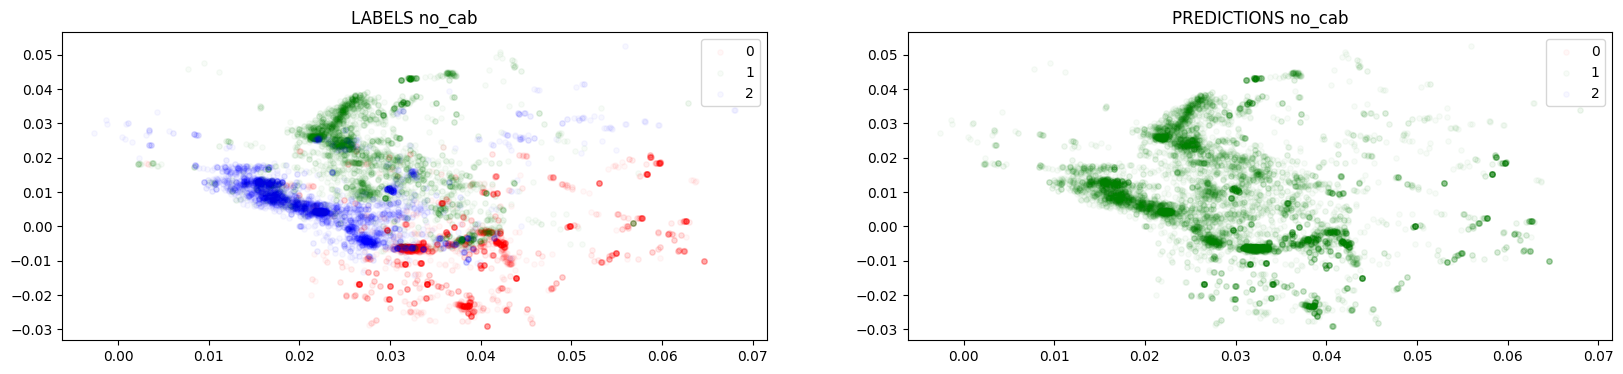

Epoch 1, Test Accuracy: 0.9065
Epoch 11, Test Accuracy: 0.9049
Epoch 21, Test Accuracy: 0.9198
Accuracy finale:  0.9145748987854251


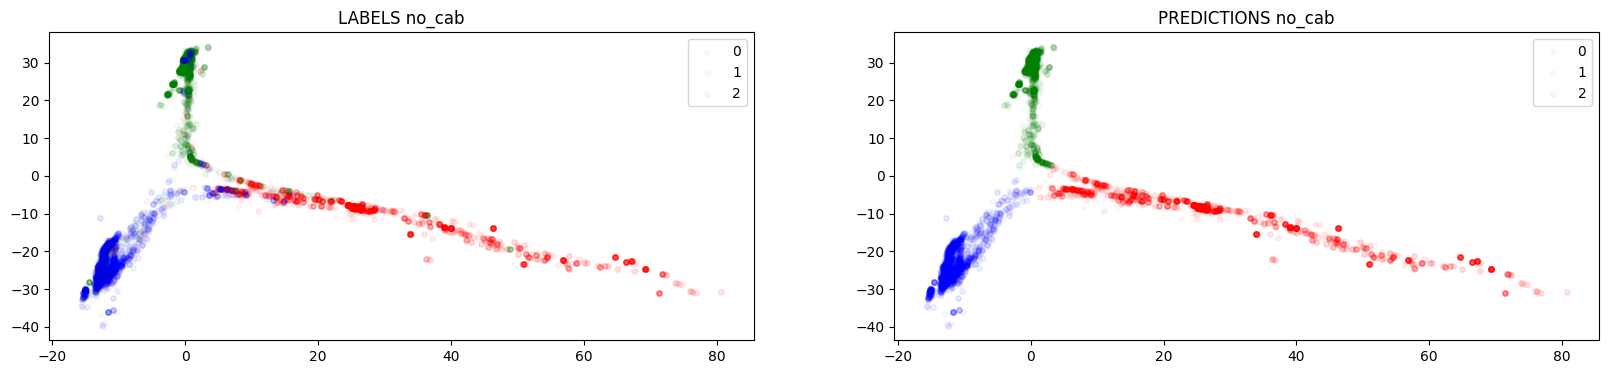

In [ ]:
X_status = dataset_new[no_silver_bullet_feat_set].values
anomaly_classifier = MLP(
    **{
        'input_dim': X_status.shape[1],
        'output_dim': 3,
        'layer_norm': True,
        'mode':'OF'})


Y = Y_status
X_train, X_test, Y_train, Y_test = train_test_split(X_status, Y, test_size=0.2, random_state=42)

train_scaler = MinMaxScaler()
X_train_scaled = train_scaler.fit_transform(X_train)
X_test_scaled = train_scaler.transform(X_test)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(anomaly_classifier.parameters(), lr=0.001)

# plotting the manifold before training
all_X_scaled = train_scaler.transform(X_status)
all_X_scaled = torch.Tensor(all_X_scaled).float()
anomaly_classifier.eval()
all_preds, manifold = anomaly_classifier(all_X_scaled)
all_preds = torch.argmax(all_preds, dim=1)
all_correct = (all_preds == Y).sum().item()
all_accuracy = all_correct / len(Y)
print("Accuracy iniziale: ", all_accuracy)
manifold = manifold.numpy()

plot_results(Y,all_preds, manifold, "no silver bullets")

# training

train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_train_scaled).float(),
    torch.tensor(Y_train).long())
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(X_test_scaled).float(),
    torch.tensor(Y_test).long())

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False)

for epoch in range(30):
    anomaly_classifier.train()
    for x, y in train_dataloader:
        optimizer.zero_grad()
        output, _ = anomaly_classifier(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

    anomaly_classifier.eval()
    total_correct = 0
    with torch.no_grad():
        for x, y in test_dataloader:
            output, _ = anomaly_classifier(x)
            predicted = torch.argmax(output, dim=1)
            total_correct += (predicted == y).sum().item()
    accuracy = total_correct / len(test_dataset)
    if epoch%10==0:
        print(f'Epoch {epoch+1}, Test Accuracy: {accuracy:.4f}')

# final plot:
all_X_scaled = train_scaler.transform(X_status)
all_X_scaled = torch.Tensor(all_X_scaled).float()
anomaly_classifier.eval()
all_preds, manifold = anomaly_classifier(all_X_scaled)
all_preds = torch.argmax(all_preds, dim=1)
all_correct = (all_preds == Y).sum().item()
all_accuracy = all_correct / len(Y)
print("Accuracy finale: ", all_accuracy)
manifold = manifold.numpy()

plot_results(Y,all_preds, manifold, "no silver bullets")

not pretty silver yet... let's iterate

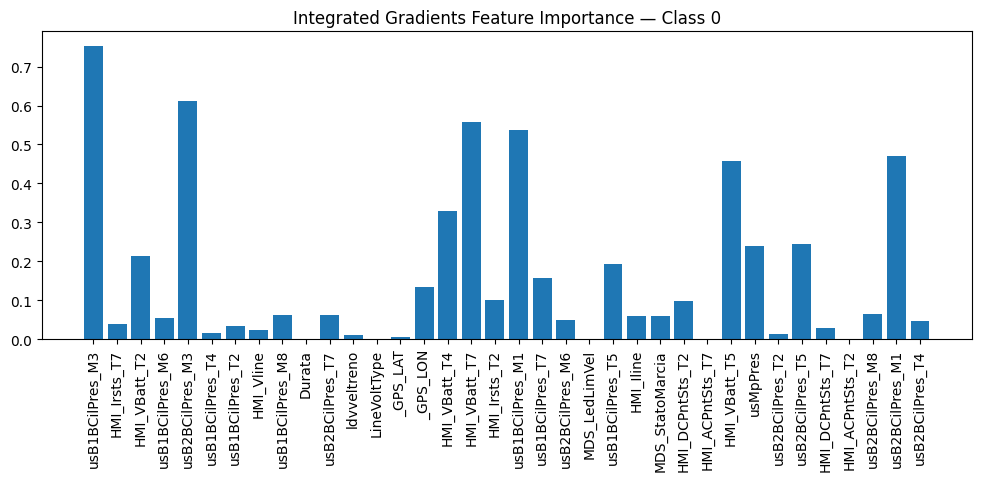

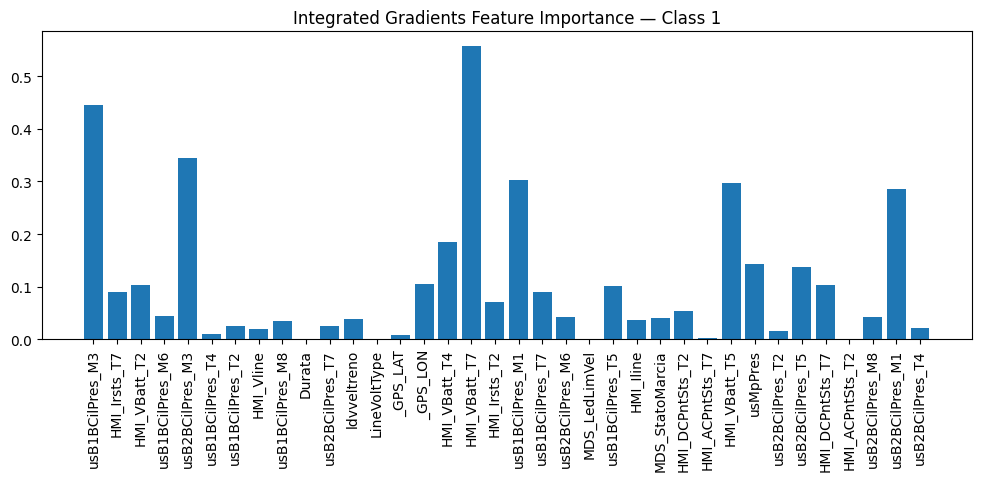

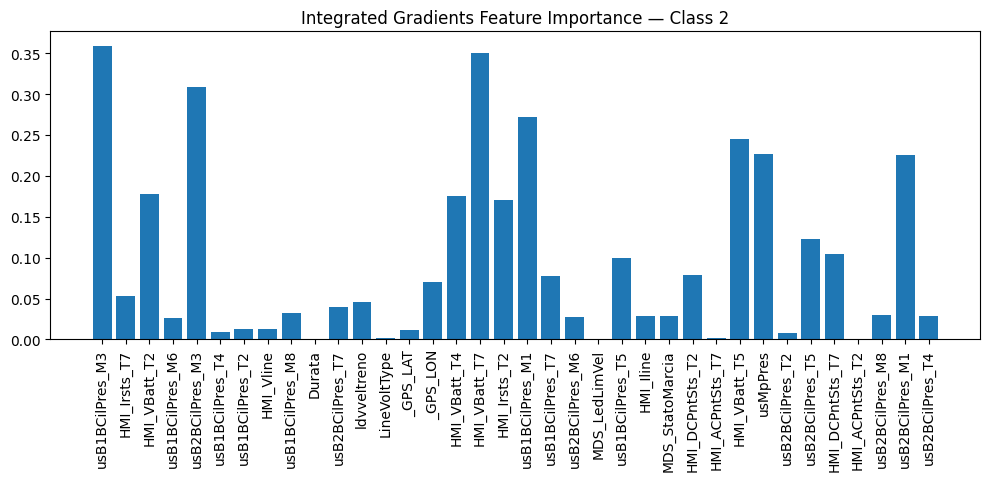

In [84]:
from captum.attr import IntegratedGradients

class MLPLogits(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base = base_model

    def forward(self, x):
        logits, _ = self.base(x)
        return logits

logit_model = MLPLogits(anomaly_classifier).eval()

for target_class in [0,1,2]:
        
    ig = IntegratedGradients(logit_model)

    x = torch.tensor(X_test_scaled).float()

    attributions, _ = ig.attribute(
        x,
        target=target_class,
        return_convergence_delta=True,
        n_steps=100
    )

    attr = attributions.detach().numpy()  # shape (N, features)

    mean_attr = np.mean(np.abs(attr), axis=0)

    plt.figure(figsize=(12, 4))
    plt.bar(no_silver_bullet_feat_set, mean_attr)
    plt.xticks(rotation=90)
    plt.title(f"Integrated Gradients Feature Importance — Class {target_class}")
    plt.show()


Now it is really clear there are NO SILVER BULLETS in this prediction game.